In [16]:
import cv2
import dlib
import numpy as np
import csv
import matplotlib.pyplot as plt

In [62]:
class Preprocessing():
    #--------лицо ли это?---------
    def isface(self, points):
        if (points[0,0] < points[1, 0]) and (points[2,1] > points[1, 1]) and (points[2,1]> points[0,1]):
            return True
        else:
            return False
    #----выделение точек лице------
    def points_for_affin(self, points):
        _pfa, l, r, m = [], [], [], []
        l = []
        r = []
        m = []
        l.extend(points[36:42])
        r.extend(points[42:48])
        m.extend(points[48:61])
        _pfa.append(self.avarage(l))
        _pfa.append(self.avarage(r))
        _pfa.append(self.avarage(m))
        return _pfa
    #-----чтение точек из файла------
    def readpointsfromcsv(self):
        points = []
        with open("points.csv", 'r') as f:
            reader = csv.reader(f)
            for row in reader:
                point = []
                point.append(int(row[0]))
                point.append(int(row[1]))
                points.append(point)
        return points
    #------------афинное преобразование----------
    def rotateImage(self, image, angle):
        row,col = image.shape
        center=tuple(np.array([row,col])/2)
        rot_mat = cv2.getRotationMatrix2D(center,angle,1.0)
        new_image = cv2.warpAffine(image, rot_mat, (col,row))
        return new_image
    #------------------поворот лица-------------
    def turn_face(self, face, points):
        l = []
        r = []
        l.extend(points[36:42])
        r.extend(points[42:48])
        Lh = (avarage(l)[1] - avarage(r)[1])
        Lc = (avarage(l)[0] - avarage(r)[0])
        phi = math.atan(Lh/Lc)
        #print(phi*180/math.pi)
        turnface = self.rotateImage(face, phi*180/math.pi)
        return turnface
    
    #--------среднее значение координат--------------
    def avarage(self, mass):
        av = []
        tmpx = 0
        tmpy = 0
        for i in mass:
            tmpx += i[0]
            tmpy += i[1]
        av.append(tmpx/len(mass))
        av.append(tmpy/len(mass))
        return av
    #-----------трансформация--------------------
    def transform(self, face, Afin_points, face_pose_predictor):
        points=[[p.x, p.y] for p in face_pose_predictor(face, dlib.rectangle(0, 0, 300, 300)).parts()]
        pts1 = np.float32(self.points_for_affin(points))
        pts2 = np.float32(Afin_points)
        if(self.isface(pts1)):
            M = cv2.getAffineTransform(pts1,pts2)
            dst = cv2.warpAffine(face,M,(300,300))
            return dst
        else:
            None
          
    def affin_tr(self, face):
        afinpoints = self.readpointsfromcsv()
        predictor_model = "shape_predictor_68_face_landmarks.dat"
        face_pose_predictor = dlib.shape_predictor(predictor_model)
        return self.transform(face, afinpoints, face_pose_predictor)
      
    #--------улучшение четкости------
    def sharpening(self, im):
        kernel_sharpen_3 = np.array ([[- 1, -1, -1, -1, -1],
                                  [-1,2,2,2, -1],
                                  [-1,2,8,2, -1],
                                  [-1,2,2,2, -1],
                                  [-1, -1, -1, -1, -1]]) / 8.0
        return cv2.filter2D (im, -1, kernel_sharpen_3)
    
    #---------------выравнивание гистаграм--------------
    def CLAHE(self, img):
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl1 = clahe.apply(img)
        return cl1
    #-------------деблюр---------
    def MedianBlurefilter(self, img, size):
        return cv2.medianBlur(img, size)

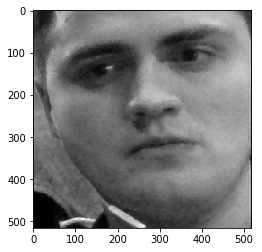

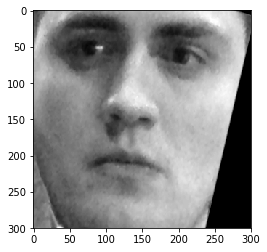

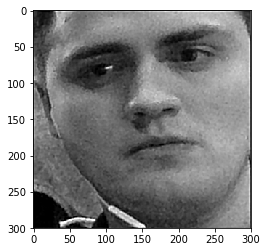

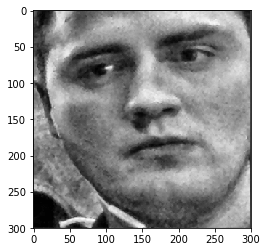

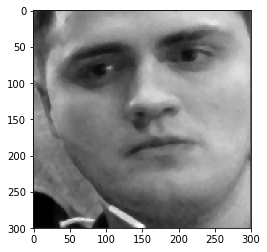

In [67]:
face = cv2.imread('123.png', 0)
plt.figure()
plt.imshow(face, cmap = 'gray')
prep = Preprocessing()

#афинные преобразования
face = cv2.resize(face, (300, 300))
tr_face = prep.affin_tr(face)
plt.figure()
plt.imshow(tr_face, cmap = 'gray')

#sharping
sh_face = prep.sharpening(face)
plt.figure()
plt.imshow(sh_face, cmap = 'gray')

#clahe
clahe_face = prep.CLAHE(face)
plt.figure()
plt.imshow(clahe_face, cmap = 'gray')

#deblure
deblur_face = prep.MedianBlurefilter(face, 5)
plt.figure()
plt.imshow(deblur_face, cmap = 'gray')